<a href="https://colab.research.google.com/github/iris-baptista/daa_seamCarving/blob/main/G20_111812_EurisaPatricio_122701_IrisBaptista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Minitrabalho DAA - "*Seam Carving*"
# Ano Letivo 2024/2025

## 1. Bibliotecas Importadas

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
from scipy.ndimage import sobel
from collections import defaultdict
import sys

## 2. Representação de Dados

### 2.1 Como está a representar a energia dos pixels no seu grafo? Qual foi o critério para esta escolha? Que tipo de grafo representa o problema em questão?

***Optou-se por representar a energia dos pixels como peso das arestas no grafo.***

Os **nós/vértices** estarão associados aos pixels da imagem, e o **peso das arestas** corresponderão à energia de cada pixel **sucessor/destino**, que neste caso será calculada com base na combinação linear do valor da intensidade dos pixels na sua vizinhança inferior, conforme mencionado no enunciado. Contudo, sabe-se que o grafo será um digrafo, pesado e acíclico, ou seja um DAG, O que será útil para encontrarmos o caminho mais curto, ou seja, com menor energia, e, posteriormente, fazermos a sua remoção.

### 2.2 Qual é a representação computacional de grafo que está a utilizar? Por exemplo, matriz de adjacência, lista/mapa de adjacências ou uma outra alternativa?

A representação computacional do grafo que iremos utilizar é o **Mapa de Adjacências**, um dicionário onde cada pixel terá como valor outro dicionário que apontará para os seus vizinhos inferiores, sendo o respetivo valor de cada vizinho uma aresta (tendo a sua respetiva energia como peso).

### 2.3 Identifique as vantagens e desvantagens da sua representação de grafo escolhida e os critérios utilizados para a sua escolha. Por exemplo, a sua escolha facilita a implementação de alguma operação específica? Ou faz com que as operações fiquem mais eficientes (em relação ao tempo e ao espaço em memória)?

Neste problema, identificamos que o grafo será esparso. Ele terá aproximadamente W × H vértices e, em média, m ≈ 3WH arestas, pois cada vértice pode se conectar a no máximo 3 vizinhos inferiores.
Assim, a densidade do grafo será:

                           m / n² ≈ 3 / (W × H)

Como este valor é muito baixo e m « n², podemos concluir que é  mesmo um grafo esparso.
Sendo assim vantajoso usar um mapa de adjacências.


**Vantagens:**
- Melhor uso da memória (O(n + m)).
- Verificação e inserção de arestas em tempo O(1).
- Permite associar informações (como energia) diretamente às arestas.

**Desvantagens:**
- Menos eficiente em grafos densos (o que não é o caso).


### 2.4 Se optou por utilizar as classes Graph/Digraph fornecidas na Semana 6 para a sua solução, identifique também as possíveis modificações que teve de realizar nas classes.

Utilizamos a classe Graph (Vertex e Edge) e fizemos as seguintes modificações:


*   Alteramos os atributos do ***Vertex***, em vez de ***id***, usamos as coordenada ***(x,y)***.
*   Definimos o algoritmo de pesquisa do ***shortest-path*** (*topological order*) dentro da classe ***Graph***.



## 3. API Seam Carving

Disclaimer:
* Para facilitar a execução e não ter várias células de código ao longo do relatório, decidimos juntar tudo no fim num subcapítulo, 3.5.
* Na análise das funções, considerámos como operações elementares:
  * Operações aritméticas.
  * Comparações.
  * Acessos à memória.
  * Chamadas as funções.
* Em função da dimensão da imagem, temos **W** (weight) como a largura e **H** (height) como a altura.

### 3.1 Estrutura de Dados

In [ ]:
class Vertex:
    def __init__(self, y, x):
        self.y = y
        self.x = x

    def __hash__(self):
        return hash((self.y, self.x))

    def __eq__(self, other):
        return self.y == other.y and self.x == other.x

    def __repr__(self):
        return f"Vertex({self.y}, {self.x})"

class Edge:
    def __init__(self, from_vertex, to_vertex, weight):
        self.from_vertex = from_vertex
        self.to_vertex = to_vertex
        self.weight = weight

    def __repr__(self):
        return f"Edge({self.from_vertex} -> {self.to_vertex}, weight={self.weight})"

class Graph:
    def __init__(self, height, width):
        self.height = height
        self.width = width
        self.adjacency_list = {}

    def add_vertex(self, vertex):
        if vertex not in self.adjacency_list:
            self.adjacency_list[vertex] = []

    def add_edge(self, from_vertex, to_vertex, weight):
        self.add_vertex(from_vertex)
        self.add_vertex(to_vertex)
        edge = Edge(from_vertex, to_vertex, weight)
        self.adjacency_list[from_vertex].append(edge)

    def get_neighbors(self, vertex):
        return self.adjacency_list.get(vertex, [])

    def topological_sort(self):
        visited = set()
        result = []

        def dfs(vertex):
            if vertex not in visited:
                visited.add(vertex)
                for edge in self.get_neighbors(vertex):
                    dfs(edge.to_vertex)
                result.append(vertex)

        for vertex in self.adjacency_list:
            if vertex not in visited:
                dfs(vertex)

        return result[::-1]

Estimativa de Espaço Ocupado:

In [ ]:
img = np.array(Image.open("test_small.png"))
x,y,c=img.shape
size = sys.getsizeof(img)
print("Dimensões da imagem: " + x.__str__() + "x" + y.__str__())
print("A estrutura de dados ocupa: " + size.__str__() + " bytes.")

Dimensões da imagem: 61x120
A estrutura de dados ocupa: 29424 bytes.


### 3.2 Calcular a energia da imagem

3.2.1 Implemente e teste a função auxiliar _calculate_energy() que irá calcular a energia da imagem atual. A função deve devolver o mapa da energia da imagem como um ndarray (numpy array).



```
def _calculate_energy(self):
        gray = np.dot(self.image[..., :3], [0.299, 0.587, 0.114])
        dx = sobel(gray, axis=1, mode='constant')
        dy = sobel(gray, axis=0, mode='constant')
        energy = np.hypot(dx, dy)
        return energy
```



3.2.2 Apresente uma análise da complexidade desta função em relação ao tempo e ao espaço extra de memória utilizados (em função da dimensão da imagem).

Começando pela primeira linha de código, convertemos a imagem para *greyscale* realizando o **produto escalar** entre os valores RGB de cada coordenada com o vetor de valores constantes (0,299; 0.587; 0.114). Isto é:

> $3 . O(W . H) = O(W . H)$

No cálculo dos gradientes, **$Δ_x(x,y)$** e **$Δ_y(x,y)$**, a operação *sobel*, descrita abaixo:


```
 def sobel(input, axis, output=None, mode, cval=0.0):
    input = np.asarray(input)
    axis = normalize_axis_index(axis, input.ndim)
    output = _ni_support._get_output(output, input)
    modes = _ni_support._normalize_sequence(mode, input.ndim)
    correlate1d(input, [-1, 0, 1], axis, output, modes[axis], cval, 0)
    axes = [ii for ii in range(input.ndim) if ii != axis]
    for ii in axes:
        correlate1d(output, [1, 2, 1], ii, output, modes[ii], cval, 0)
    return output
```
*Source: https://github.com/scipy/scipy/blob/v1.15.3/scipy/ndimage/_filters.py#L0-L1 (line 496)*

 - Passa todos os valores RGB de cada pixel para um array, *input*. $3 . O(W . H)$
 - Operação constante, logo $O(1)$
 - Cria um array do tamanho da imagem, logo: $3 . O(W . H)$
 - Operação constante, logo $O(1)$
 - Correlação dado um certo axis, $3 . O(W . H)$
 - Operação constante, $O(1)$
 - Novamente correlação, $3 . O(W . H)$

Resumidamente, este passo terá um tempo de execução O(W x H).

Calculando finalmente a energia de todos os pixels, isto é: $\sqrt{Δ_x^{2}(x,y) + Δ_y^{2}(x,y)}$

Conclusão, o tempo de excução, no pior caso, será: $3 . O(W . H) + 2 . (10 . O(W . H) + 3 . O(1)) + O(W . H) = O(W . H) $

### 3.3 Encontrar a costura de menor energia (steam).

3.3.1 Descreva os passos e as modificações realizadas no grafo e/ou no algoritmo para reduzir o problema do seam carving para o problema do caminho mais curto num grafo (shortest path). Indique qual algoritmo shortest path que escolheu implementar e o motivo da sua escolha.

As modificações feitas já foram apresentadas no subcapítulo 2.4. Quanto ao algoritmo shortest-path, tendo em conta que estamos perante um problema com um grafo direcionado e acíclico (DAG) cujos pesos são não negativos, implementámos o algoritmo de ordenação topológica com Depth-First Search.

3.3.2 Implemente e teste o método find_vertical_seam() que deverá encontrar o caminho de menor energia.

```
def find_vertical_seam(self):
    h, w = self.energy.shape
    dist_to = np.full((h, w), np.inf)
    edge_to = np.zeros((h, w), dtype=int)

    dist_to[0] = self.energy[0]

    for y in range(1, h):
        for x in range(w):
            for dx in [-1, 0, 1]:
                prev_x = x + dx
                if 0 <= prev_x < w:
                    if dist_to[y, x] > dist_to[y - 1, prev_x] + self.energy[y, x]:
                        dist_to[y, x] = dist_to[y - 1, prev_x] + self.energy[y, x]
                        edge_to[y, x] = prev_x

    seam = []
    x = np.argmin(dist_to[-1])
    for y in reversed(range(h)):
        seam.append(x)
        x = edge_to[y, x]
    seam.reverse()
    return seam
```

3.3.3 Apresente uma análise completa da complexidade do seu algoritmo em função da dimensão da imagem, e compare-a com a complexidade de outras versões do algoritmo shortest path.

Inicializamos a função:
 - Indo buscar as dimensões da imagem, usando a função shape() que tem um custo de $O(1)$.
 - Criando um array dist_to, preenchido com $∞$ floating point, de dimensão $O(W . H)$
 - Criando um array edge_to, preenchido com zeros (int), de dimensão $O(W . H)$
 - Preenchemos a primeira linha de dist_to, $O(W)$

Número de iterações:
  - Loop $y$: $H-1$
  - Loop $x$: $W$
  - Loop $dx$: $3$

Número total de iterações nos loops: $(H-1) . (W) . 3 = O(W . H)$


Dentro dos loops temos operações elementares, ou seja, de custo $O(1)$.

Na parte da reconstrução da costura:
 - A primeira operação é elementar, logo $O(1)$
 - Guarda numa variável um array de tamanho $O(W)$
 - O loop de $y$ corre $H$ vezes
  * Dentro do loop tem operações elementares de custo $O(1)$
 - Logo, vai ter um custo de $O(W) + O(H)$

Reverse operation: $O(H)$

A complexidade total será de:

> $O(1) + O(W.H) + O(W.H) + O(W) + O(W.H) + O(1) + O(W) + O(1) + O(W) + O(H) + O(H) = O(W.H)$

3.3.4 Analise e compare a complexidade do seu algoritmo baseado em grafos com uma solução que utiliza a estratégia de programação dinâmica. Na sua pesquisa bibliográfica e análise, deve usar fontes credíveis, tais como, artigos científicos, manuais técnicos ou recursos webgráficos devidamente acreditados.

Vamos mostrar os resultados com diferentes implementações de SeamCarving:
1. Brute Force Algorithm

> $T(n,n) = 0(n.3^{n})$

2. Greedy Algorithm

> $T(n,n) = O(n)$

3. Dynamic Algorithm

> $T(n,n) = O(n^{2})$

4. GPU parallelized Algorithm

> $T(n,n) = O(n)$

Sources:
- https://arxiv.org/html/2410.21207v1#S5
- https://pacman.cs.tsinghua.edu.cn/~cwg/papers_cwg/icpads14.pdf



### 3.4 Remover uma costura (steam) da imagem.

3.4.1 Implemente e teste o método remove_vertical_steam(steam) que recebe uma coleção com a sequência de pixels da costura, steam, e remove-os da imagem atual.



```
def remove_vertical_seam(self, seam):
    h, w, c = self.image.shape
    new_img = np.zeros((h, w - 1, c))
    for y in range(h):
        x = seam[y]
        new_img[y, :, :] = np.delete(self.image[y, :, :], x, axis=0)
    self.image = new_img
    self.height, self.width = self.image.shape[:2]
    self.energy = self._calculate_energy()
```



3.4.2 Apresente uma análise da complexidade desta operação em função da dimensão da imagem.

Tendo em conta que temos uma imagem com dimensões $H$ x $W$ x $C$:
- Encontrar a costura de menor energia que terá complexidade $O(W.H)$
- Para cada linha ($H$), remover 1 pixel (de $W$ pixels) que tem de custo $O(W)$ por linha, ou seja, $O(W.H)$.

No final, terá uma complexidade $O(W.H)$, isto é, linear em relação ao número de pixels da imagem.


###3.5 Classe SeamCarving

In [ ]:
class SeamCarving:
    def __init__(self, image):
        self.image = image.astype(np.float64)
        self.height, self.width, _ = self.image.shape
        self.energy = self._calculate_energy()

    def _calculate_energy(self):
        gray = np.dot(self.image[..., :3], [0.299, 0.587, 0.114])
        dx = sobel(gray, axis=1, mode='constant')
        dy = sobel(gray, axis=0, mode='constant')
        energy = np.hypot(dx, dy)
        return energy

    def find_vertical_seam(self):
        h, w = self.energy.shape
        dist_to = np.full((h, w), np.inf)
        edge_to = np.zeros((h, w), dtype=int)

        dist_to[0] = self.energy[0]

        for y in range(1, h):
            for x in range(w):
                for dx in [-1, 0, 1]:
                    prev_x = x + dx
                    if 0 <= prev_x < w:
                        if dist_to[y, x] > dist_to[y - 1, prev_x] + self.energy[y, x]:
                            dist_to[y, x] = dist_to[y - 1, prev_x] + self.energy[y, x]
                            edge_to[y, x] = prev_x

        # Reconstroi o caminho do menor custo
        seam = []
        x = np.argmin(dist_to[-1])
        for y in reversed(range(h)):
            seam.append(x)
            x = edge_to[y, x]
        seam.reverse()
        return seam

    def remove_vertical_seam(self, seam):
        h, w, c = self.image.shape
        new_img = np.zeros((h, w - 1, c))
        for y in range(h):
            x = seam[y]
            new_img[y, :, :] = np.delete(self.image[y, :, :], x, axis=0)
        self.image = new_img
        self.height, self.width = self.image.shape[:2]
        self.energy = self._calculate_energy()

    def picture(self):
        return self.image.astype(np.uint8)

## 4. Validação

### 4.1 Crie uma função que receba uma imagem e um fator de escala como entrada, e que devolva a imagem redimensionada utilizando a API SeamCarving. A função deve ser capaz de lidar com o redimensionamento da largura e da altura de uma imagem, consoante a escolha do utilizador.

In [ ]:
def resize_image_seam_carving(image, scale_width=1.0, scale_height=1.0):
    sc = SeamCarving(image.copy())

    target_width = int(sc.width * scale_width)
    target_height = int(sc.height * scale_height)

    while sc.width > target_width:
        seam = sc.find_vertical_seam()
        sc.remove_vertical_seam(seam)

    if sc.height > target_height:
        sc.image = np.transpose(sc.image, (1, 0, 2))
        sc.energy = sc._calculate_energy()
        sc.height, sc.width = sc.image.shape[:2]

        while sc.width > target_height:
            seam = sc.find_vertical_seam()
            sc.remove_vertical_seam(seam)

        sc.image = np.transpose(sc.image, (1, 0, 2))
        sc.energy = sc._calculate_energy()
        sc.height, sc.width = sc.image.shape[:2]

    return sc.picture()

### 4.2 Reduza a largura da imagem img-broadway_tower.jpg para 70% da sua largura original, utilizando a função implementada. O resultado deve ser apresentado no próprio notebook.

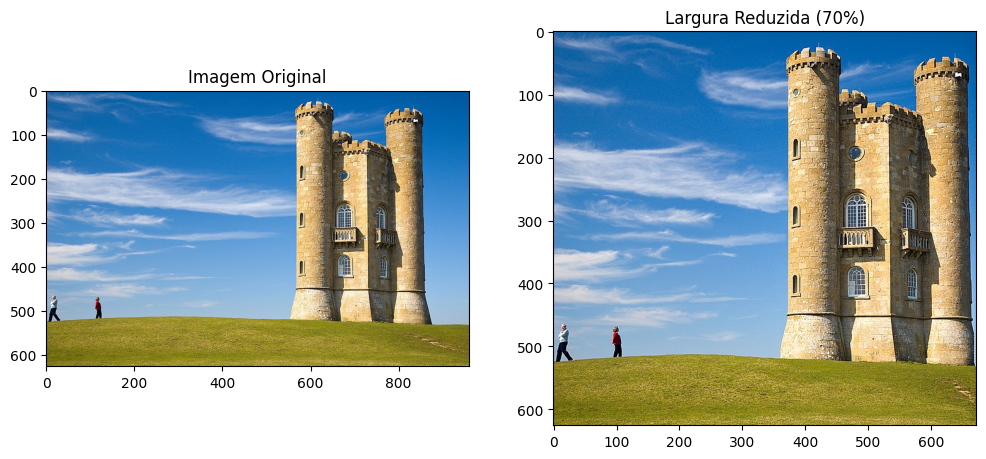

In [ ]:
img1 = mpimg.imread("img-broadway_tower.jpg")
resized_img1 = resize_image_seam_carving(img1, scale_width=0.7)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Imagem Original")

plt.subplot(1, 2, 2)
plt.imshow(resized_img1)
plt.title("Largura Reduzida (70%)")

plt.show()

### 4.3 Reduza a largura da imagem img-brent-cox-unsplash.jpg para 60% da sua altura original, utilizando a função implementada. O resultado deve ser apresentado no próprio notebook.

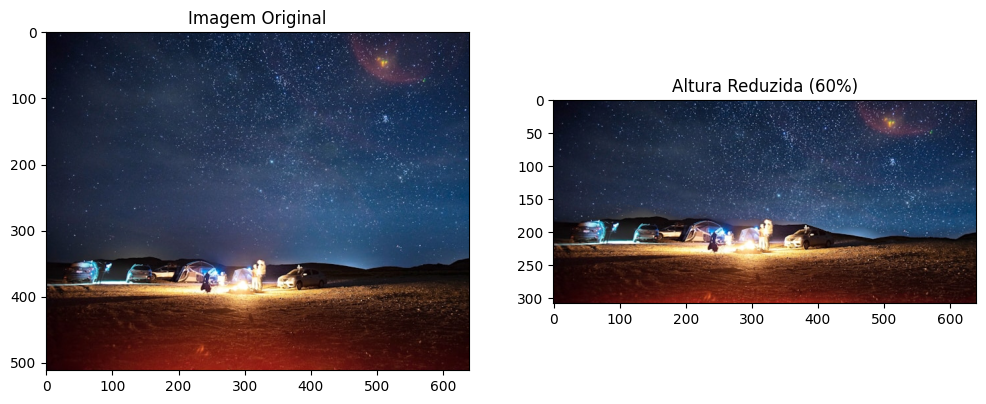

In [ ]:
img = mpimg.imread("img-brent-cox-unsplash.jpg")

resized_img = resize_image_seam_carving(img, scale_width=1.0, scale_height=0.6)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Imagem Original")

plt.subplot(1, 2, 2)
plt.imshow(resized_img)
plt.title("Altura Reduzida (60%)")

plt.show()

## 5. Questões Éticas

### a) Se colaborou com alguém fora do seu grupo, indique aqui os respetivos nomes.

Não.

### b) Deve citar todas as fontes utilizadas fora do material da UC.

* Image Gradient: https://en.wikipedia.org/wiki/Image_gradientSobel
* Operator: https://en.wikipedia.org/wiki/Sobel_operator
